In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True)

In [4]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

In [5]:
train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_data = datasets.MNIST(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


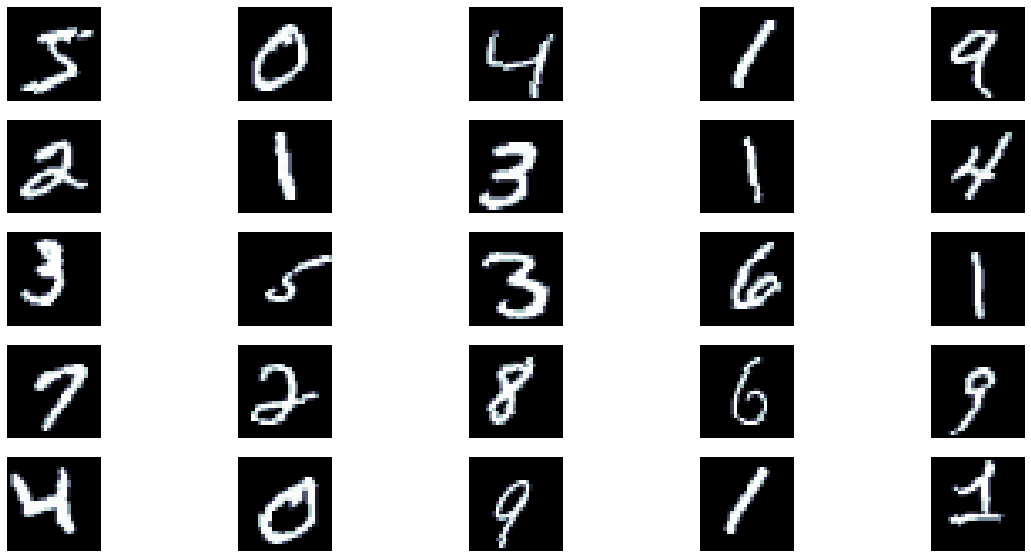

In [7]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [9]:
BATCH_SIZE = 120

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        
        #x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        
        #h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        
        #y_pred = [batch size, output dim]
        
        return y_pred, h_2
    
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [11]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [12]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 12s
	Train Loss: 0.471 | Train Acc: 85.47%
	 Val. Loss: 0.164 |  Val. Acc: 94.88%
Epoch: 02 | Time: 0m 13s
	Train Loss: 0.185 | Train Acc: 94.35%
	 Val. Loss: 0.125 |  Val. Acc: 96.12%
Epoch: 03 | Time: 0m 14s
	Train Loss: 0.141 | Train Acc: 95.61%
	 Val. Loss: 0.087 |  Val. Acc: 97.05%
Epoch: 04 | Time: 0m 15s
	Train Loss: 0.123 | Train Acc: 96.17%
	 Val. Loss: 0.095 |  Val. Acc: 96.92%
Epoch: 05 | Time: 0m 15s
	Train Loss: 0.111 | Train Acc: 96.57%
	 Val. Loss: 0.078 |  Val. Acc: 97.47%
Epoch: 06 | Time: 0m 15s
	Train Loss: 0.100 | Train Acc: 96.96%
	 Val. Loss: 0.067 |  Val. Acc: 97.70%
Epoch: 07 | Time: 0m 15s
	Train Loss: 0.093 | Train Acc: 97.05%
	 Val. Loss: 0.067 |  Val. Acc: 97.75%
Epoch: 08 | Time: 0m 15s
	Train Loss: 0.086 | Train Acc: 97.28%
	 Val. Loss: 0.068 |  Val. Acc: 97.92%
Epoch: 09 | Time: 0m 15s
	Train Loss: 0.084 | Train Acc: 97.40%
	 Val. Loss: 0.068 |  Val. Acc: 97.65%
Epoch: 10 | Time: 0m 15s
	Train Loss: 0.078 | Train Acc: 97.51%
	 Val. Lo

In [14]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.063 | Test Acc: 97.93%


In [15]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [16]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

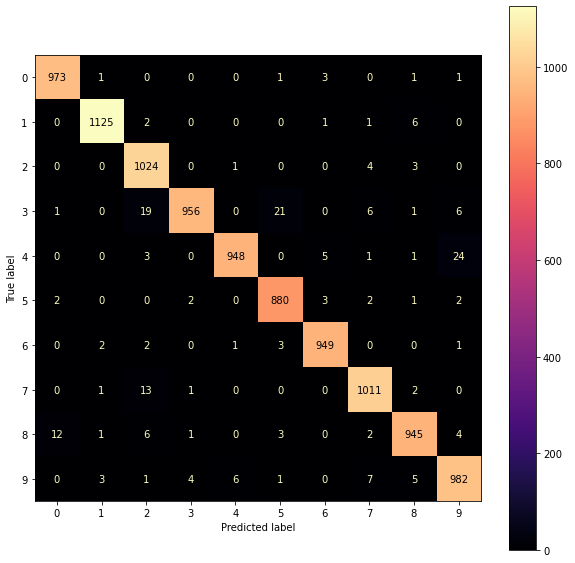

In [17]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'magma', ax = ax)
    
plot_confusion_matrix(labels, pred_labels)

In [18]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

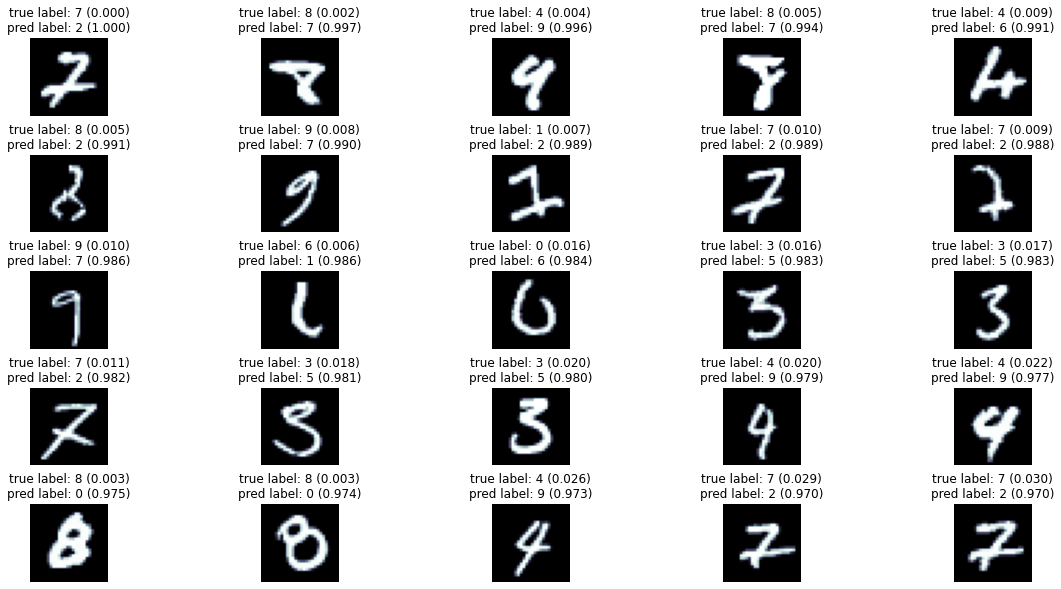

In [19]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)